# Обучение с учителем: качество модели

***Описание проекта:***

- Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

***Цель проекта:***

- Цель - разработка решения, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

***Задачи:***

- Промаркировать уровень финансовой активности постоянных покупателей. 
- Собрать данные по клиентам.
- Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

***Исходные данные:***

*Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. - `market_file.csv`*
  - `id` - номер покупателя в корпоративной базе данных.
  - `Покупательская активность` -  рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
  - `Тип сервиса` -  уровень сервиса, например «премиум» и «стандарт».
  - `Разрешить сообщать` - информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
  - `Маркет_актив_6_мес` - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
  - `Маркет_актив_тек_мес` - количество маркетинговых коммуникаций в текущем месяце.
  - `Длительность` - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
  - `Акционные_покупки` - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
  - `Популярная_категория` - самая популярная категория товаров у покупателя за последние 6 месяцев.
  - `Средний_просмотр_категорий_за_визит` - показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
  - `Неоплаченные_продукты_штук_квартал` - общее число неоплаченных товаров в корзине за последние 3 месяца.
  - `Ошибка_сервиса` - число сбоев, которые коснулись покупателя во время посещения сайта.
  - `Страниц_за_визит` - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
  
*Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. - `market_money.csv`*
  - `id` - номер покупателя в корпоративной базе данных.
  - `Период` - название периода, во время которого зафиксирована выручка. Например, `текущий_месяц` или `предыдущий_месяц`.
  - `Выручка` - сумма выручки за период.
  
*Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода. - `market_time.csv`*
  - `id` - номер покупателя в корпоративной базе данных.
  - `Период` - название периода, во время которого зафиксировано общее время.
  - `минут` - значение времени, проведённого на сайте, в минутах.

*Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. - `money.csv`*
  - `id` - номер покупателя в корпоративной базе данных.
  - `Прибыль` - значение прибыли.

## Загрузка данных

In [1]:
!pip install scikit-learn==1.1.0 -q
!pip install matplotlib==3.5.1 -q
!pip install shap 
!pip install phik
!pip install missingno

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

import shap
import missingno as msno

from warnings import simplefilter
from scipy.stats import ttest_ind, shapiro

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
#Отключаем предупреждения
simplefilter(action='ignore', category=FutureWarning)

In [4]:
#Загружаем исходные датасеты и сохраняем их в переменные
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')

In [5]:
#Выводим первые 5 строк на экран
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
#Изучаем датасет методом info()
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [7]:
#Получаем описательные статистики методом describe()
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [8]:
#Выводим первые 5 строк на экран
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [9]:
#Изучаем датасет методом info()
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [10]:
#Получаем описательные статистики методом describe()
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [11]:
#Выводим первые 5 строк на экран
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [12]:
#Изучаем датасет методом info()
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [13]:
#Получаем описательные статистики методом describe()
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [14]:
#Выводим первые 5 строк на экран
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [15]:
#Изучаем датасет методом info()
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [16]:
#Получаем описательные статистики методом describe()
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


**Вывод по блоку "Загрузка данных":**

 - Данные всех датасетов загружены верно, типы данных не требуют преобразования, все данные соответствуют описанию.
   - Датасет `market_file` содержит 1300 строк и 13 колонок с числовыми и строковыми данными.
   - Датасет `market_money` содержит 3900 строк и 3 колонки с числовыми и строковыми данными.
   - Датасет `market_time` содержит 2600 строк и 3 колонки с числовыми и строковыми данными.
   - Датасет `money` содержит 1300 строк и 2 колонки с числовыми данными.

##  Предобработка данных

In [17]:
#Проверим все датасеты на наличие пропусков
print(f'Количество пропусков для каждого столбца в датасете "market_file":\n{market_file.isna().sum()}')
print(f'\nКоличество пропусков для каждого столбца в датасете "market_money":\n{market_money.isna().sum()}')
print(f'\nКоличество пропусков для каждого столбца в датасете "market_time":\n{market_time.isna().sum()}')
print(f'\nКоличество пропусков для каждого столбца в датасете "money":\n{money.isna().sum()}')

Количество пропусков для каждого столбца в датасете "market_file":
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Количество пропусков для каждого столбца в датасете "market_money":
id         0
Период     0
Выручка    0
dtype: int64

Количество пропусков для каждого столбца в датасете "market_time":
id        0
Период    0
минут     0
dtype: int64

Количество пропусков для каждого столбца в датасете "money":
id         0
Прибыль    0
dtype: int64


*Пропуски в данных отсутствуют*

In [18]:
#Проверим все датасеты на наличие явных дубликатов
print(f'Количество явных дубликатов в датасете "market_file":  {market_file.duplicated().sum()}')
print(f'Количество явных дубликатов в датасете "market_money":  {market_money.duplicated().sum()}')
print(f'Количество явных дубликатов в датасете "market_time":  {market_time.duplicated().sum()}')
print(f'Количество явных дубликатов в датасете "money":  {money.duplicated().sum()}')

Количество явных дубликатов в датасете "market_file":  0
Количество явных дубликатов в датасете "market_money":  0
Количество явных дубликатов в датасете "market_time":  0
Количество явных дубликатов в датасете "money":  0


*Явные дубликаты в данных отсутствуют*

**При загрузке датасета `market_file` и выводе первых пяти строк были замечены неявные дубликаты в столбце `'Тип сервиса'`. Так же проверим остальные категориальные значения на наличие неявных дубликатов и других аномалий. Обработаем их.**

In [19]:
#Создадим переменную, хранящую список всех датасетов и с помощью цикла проверим все датасеты на наличие аномалий в значениях и неявные дубликаты
all_data_sets = [market_file, market_money, market_time, money]

for data in all_data_sets:
    for col in data.select_dtypes(exclude='number').columns.tolist():
        display(data[col].value_counts().reset_index())

,index,Покупательская активность
0,Прежний уровень,802
1,Снизилась,498


,index,Тип сервиса
0,стандарт,914
1,премиум,376
2,стандартт,10


,index,Разрешить сообщать
0,да,962
1,нет,338


,index,Популярная_категория
0,Товары для детей,330
1,Домашний текстиль,251
2,Косметика и аксесуары,223
3,Техника для красоты и здоровья,184
4,Мелкая бытовая техника и электроника,174
5,Кухонная посуда,138


,index,Период
0,препредыдущий_месяц,1300
1,текущий_месяц,1300
2,предыдущий_месяц,1300


,index,Период
0,текущий_месяц,1300
1,предыдцщий_месяц,1300


In [20]:
#Исправим выявленные аномалии и неявные дубликаты
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')
market_file['Популярная_категория'] = market_file['Популярная_категория'].replace('Косметика и аксесуары', 'Косметика и аксессуары')
market_money['Период'] = market_money['Период'].replace('препредыдущий_месяц', 'предпредыдущий_месяц')
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [21]:
#Проверим все датасеты после исправлений
for data in all_data_sets:
    for col in data.select_dtypes(exclude='number').columns.tolist():
        display(data[col].value_counts().reset_index())

,index,Покупательская активность
0,Прежний уровень,802
1,Снизилась,498


,index,Тип сервиса
0,стандарт,924
1,премиум,376


,index,Разрешить сообщать
0,да,962
1,нет,338


,index,Популярная_категория
0,Товары для детей,330
1,Домашний текстиль,251
2,Косметика и аксессуары,223
3,Техника для красоты и здоровья,184
4,Мелкая бытовая техника и электроника,174
5,Кухонная посуда,138


,index,Период
0,предпредыдущий_месяц,1300
1,текущий_месяц,1300
2,предыдущий_месяц,1300


,index,Период
0,текущий_месяц,1300
1,предыдущий_месяц,1300


In [22]:
#C помощью цикла приведем названия колонок в нормальный вид
for data in all_data_sets:
    data.columns = data.columns.str.lower().str.replace(' ', '_')

In [23]:
#С помощью цикла во всех датасетах сделаем индексом столбец id
for data in all_data_sets:
    data.set_index('id', inplace=True)

In [24]:
#Проверим результат преобразований
print(market_file.columns)
print(market_money.columns)
print(market_time.columns)
print(money.columns)

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['период', 'выручка'], dtype='object')
Index(['период', 'минут'], dtype='object')
Index(['прибыль'], dtype='object')


**Вывод по блоку "Предобработка данных":**

 - В представленных датасетах пропуски и явные дубликаты отсутствуют. Но были выявлены и исправлены следующие аномалии:
   - Датасет `market_file` столбец `['Тип сервиса']` - выявлен и исправлен неявный дубликат.
   - Датасет `market_file` столбец `['Популярная_категория']` - выявлено и исправлено некорректное название категории.
   - Датасет `market_money` столбец `['Период']` - выявлено и исправлено некорректное название категории.
   - Датасет `market_time` столбец `['Период']` - выявлено и исправлено некорректное название категории.
   
   - Название колонок во всех датасетах приведено в нормельный вид в соответствии с общепринятой стилистикой.
   - Для всех датасетов в качестве индекса установлен столбец id.

##  Исследовательский анализ данных

In [25]:
#Создаем функцию для построения графиков (гистограмма и диаграмма размаха) для числовых значений
def plot_data(data, x, y, z):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    
    sn.histplot(data=data, x=x, ax=axs[0], bins=40, kde=True, alpha = 0.4, color='grey')
    axs[0].set_xlabel(f'{y}')
    axs[0].set_ylabel('Количество')
    axs[0].set_title('Гистограмма')
    
    sn.boxplot(data=data, y=x, ax=axs[1], color='skyblue')
    axs[1].set_xlabel(f'{y}')
    axs[1].set_title('Диаграмма размаха')
    
    fig.suptitle(f'{z}', fontweight='bold')
    plt.show()

In [26]:
#Создаем функцию для построения графиков (гистограмма и круговая диаграмма) для категориальных значений
def plot_histogram(dataframe, column_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    colors = ['skyblue', 'grey', 'lightcoral', 'orange', 'lightgreen', 'lightseagreen']
    
    counts = dataframe[column_name].value_counts()
    legend_labels = counts.index
    
    
    axs[0].barh(counts.index, counts, color=colors[:len(counts)])
    axs[0].set_ylabel(column_name)
    axs[0].set_xlabel('Частота')
    axs[0].set_title('Гистограмма для столбца {}'.format(column_name), fontweight='bold')

    
    axs[1].pie(counts, colors=colors[:len(counts)], autopct='%1.1f%%')
    axs[1].set_title('Диаграмма для столбца {}'.format(column_name), fontweight='bold')
    axs[1].legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

In [27]:
#Создаем функцию для проверки нормальности распределения 
def check_normality(data_column, alpha=0.05):
    stat, p = shapiro(data_column)
    print('stat=%.3f, p=%.3f' % (stat, p))
    
    if p > alpha:
        print('Распределение является нормальным')
    else:
        print('Распределение не является нормальным')

***Исследовательский анализ датасета `market_file`***

In [28]:
#Выведем список колонок датасета `market_file`
market_file.columns

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

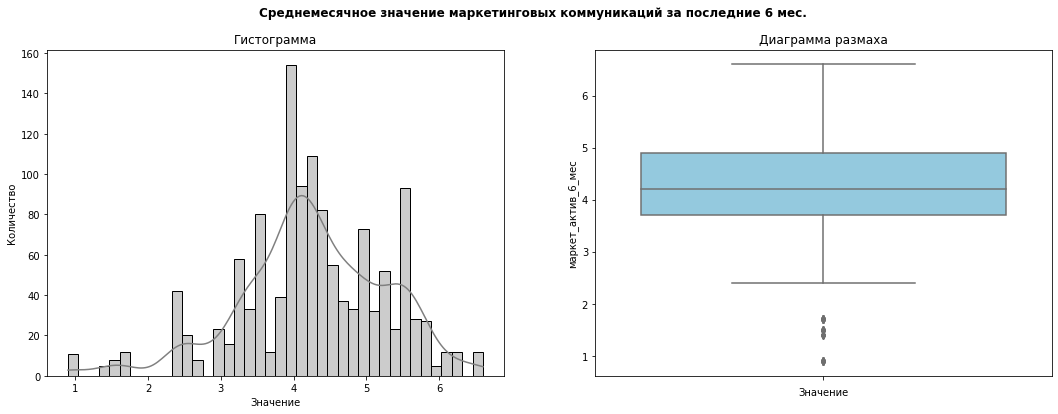

In [29]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'маркет_актив_6_мес'
plot_data(market_file, 'маркет_актив_6_мес', 'Значение', 'Среднемесячное значение маркетинговых коммуникаций за последние 6 мес.')

In [30]:
#Применяем функцию для проверки нормальности распределения к датасету `market_file` и столбцу 'маркет_актив_6_мес'
check_normality(market_file['маркет_актив_6_мес'])

stat=0.978, p=0.000
Распределение не является нормальным


In [31]:
#Выводим описательные статистики к датасету `market_file` и столбцу 'маркет_актив_6_мес'
market_file['маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

*Среднемесячное значение маркетинговых коммуникаций за последние 6 мес близко к нормальному, но всё же таковым не является. На диаграмме размаха видно несколько значений за нижней границей усов. Данные значения оставим без изменений, так как это может быть особенность работы сервиса (как вариант: недавняя регистрация пользователей)*

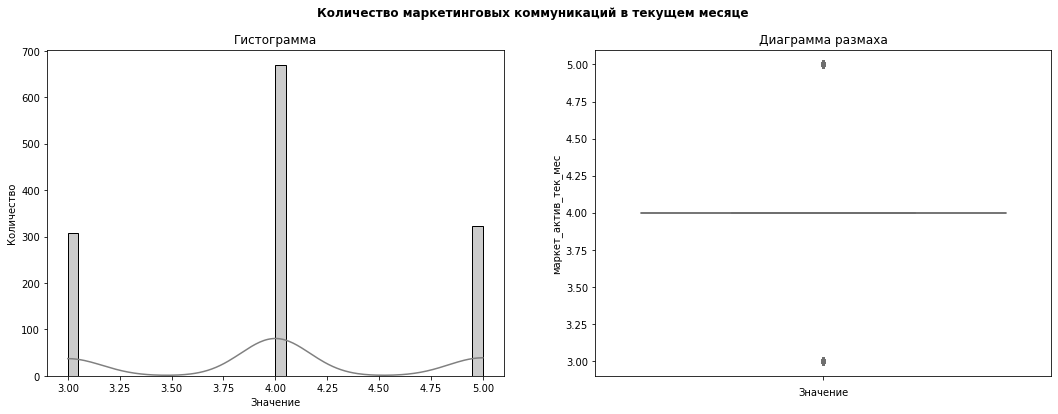

In [32]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'маркет_актив_тек_мес'
plot_data(market_file, 'маркет_актив_тек_мес', 'Значение', 'Количество маркетинговых коммуникаций в текущем месяце')

In [33]:
#Применяем функцию для проверки нормальности распределения к датасету `market_file` и столбцу 'маркет_актив_тек_мес'
check_normality(market_file['маркет_актив_тек_мес'])

stat=0.806, p=0.000
Распределение не является нормальным


In [34]:
#Выводим описательные статистики к датасету `market_file` и столбцу 'маркет_актив_тек_мес'
market_file['маркет_актив_тек_мес'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

*По гистограмме видно, что столбец 'маркет_актив_тек_мес' имеет всего 3 значения, поэтому можно предположить, что данные являются категориальными.*

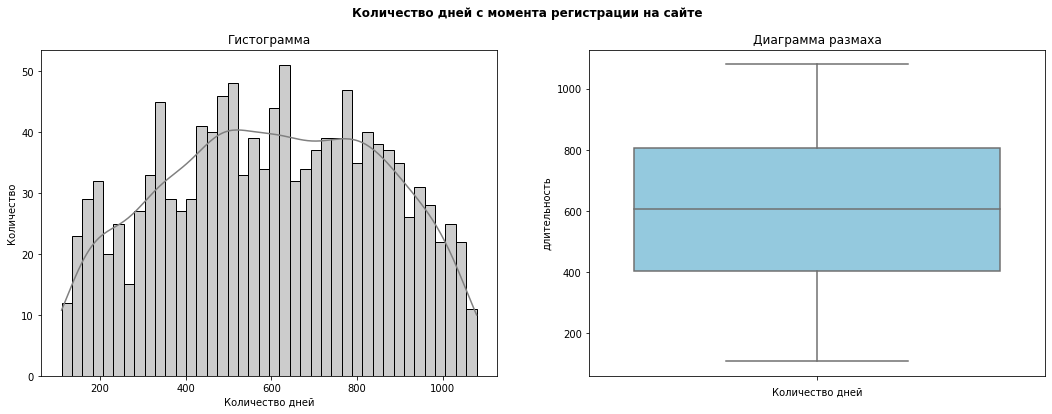

In [35]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'длительность'
plot_data(market_file, 'длительность', 'Количество дней', 'Количество дней с момента регистрации на сайте')

In [36]:
#Применяем функцию для проверки нормальности распределения к датасету `market_file` и столбцу 'длительность'
check_normality(market_file['длительность'])

stat=0.973, p=0.000
Распределение не является нормальным


In [37]:
#Выводим описательные статистики к датасету `market_file` и столбцу 'длительность'
market_file['длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

*Анализ столбца 'длительность' показал, что большая часть пользователей зарегистрирована более года. Минимальный срок регистрации 110 дней, максимальный 1079 дней.*

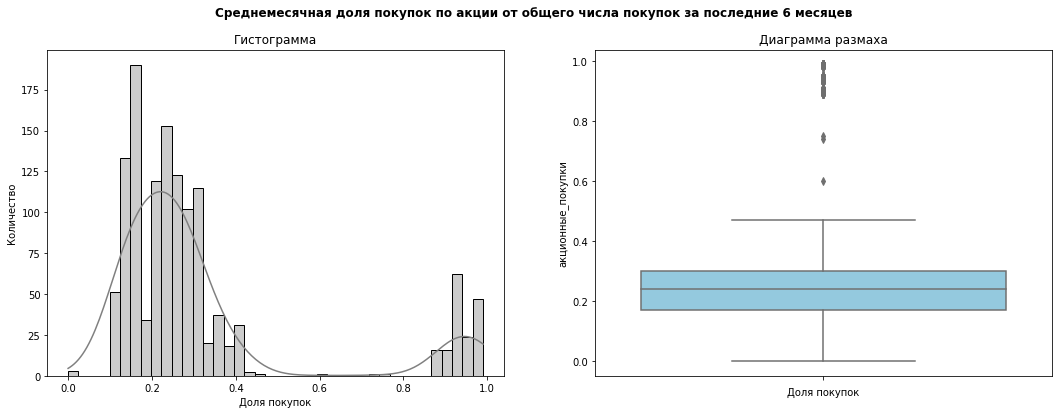

In [38]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'акционные_покупки'
plot_data(market_file, 'акционные_покупки', 'Доля покупок', 'Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')

In [39]:
#Применяем функцию для проверки нормальности распределения к датасету `market_file` и столбцу 'акционные_покупки'
check_normality(market_file['акционные_покупки'])

stat=0.662, p=0.000
Распределение не является нормальным


In [40]:
#Выводим описательные статистики к датасету `market_file` и столбцу 'акционные_покупки'
market_file['акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

*В результате анализа столбца 'акционные_покупки' было выявлено бимодальное распределение. Несмотря на то, что диаграмма размаха показывает выбросы, удалять мы их не можем.*

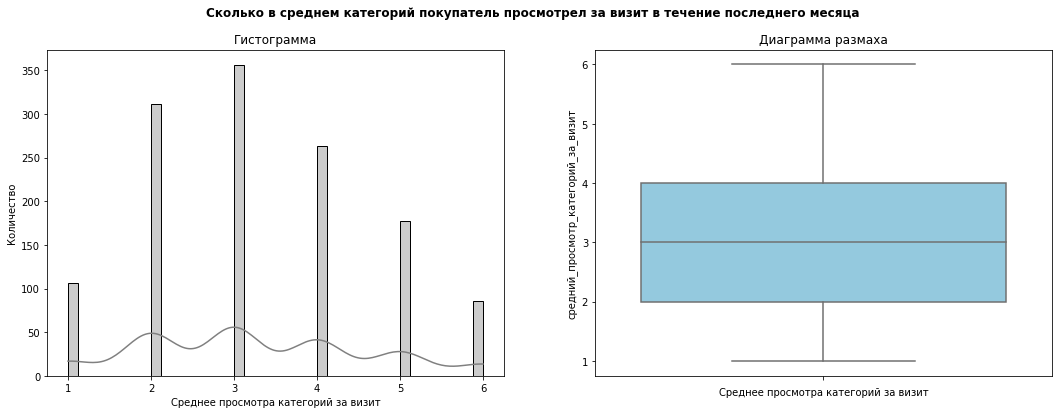

In [41]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'средний_просмотр_категорий_за_визит'
plot_data(market_file, 'средний_просмотр_категорий_за_визит', 'Среднее просмотра категорий за визит', 'Сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца')

In [42]:
#Применяем функцию для проверки нормальности распределения к датасету `market_file` и столбцу 'средний_просмотр_категорий_за_визит'
check_normality(market_file['средний_просмотр_категорий_за_визит'])

stat=0.931, p=0.000
Распределение не является нормальным


In [43]:
#Выводим описательные статистики к датасету `market_file` и столбцу 'средний_просмотр_категорий_за_визит'
market_file['средний_просмотр_категорий_за_визит'].describe()

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64

*В среднем пользователи просматривают 3 категории, просмотр минимального и максимального количества категорий примерно на одном уровне.*

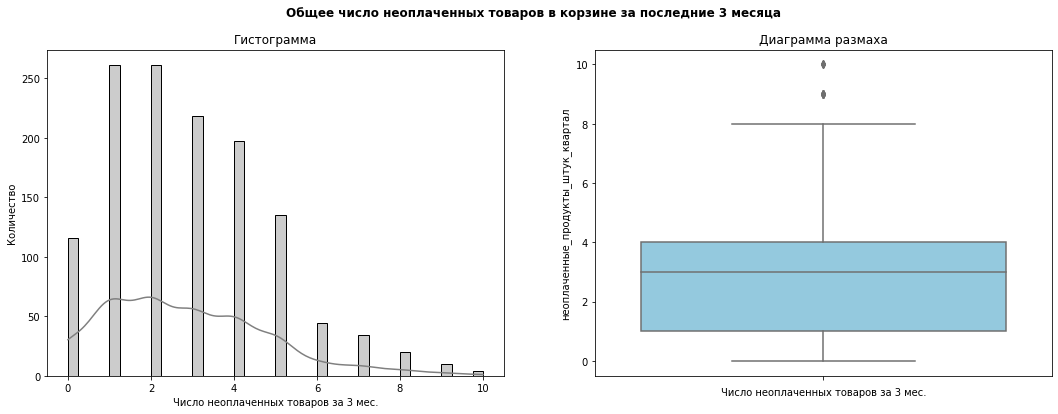

In [44]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'неоплаченные_продукты_штук_квартал'
plot_data(market_file, 'неоплаченные_продукты_штук_квартал', 'Число неоплаченных товаров за 3 мес.', 'Общее число неоплаченных товаров в корзине за последние 3 месяца')

In [45]:
#Применяем функцию для проверки нормальности распределения к датасету `market_file` и столбцу 'неоплаченные_продукты_штук_квартал'
check_normality(market_file['неоплаченные_продукты_штук_квартал'])

stat=0.933, p=0.000
Распределение не является нормальным


In [46]:
#Выводим описательные статистики к датасету `market_file` и столбцу 'неоплаченные_продукты_штук_квартал'
market_file['неоплаченные_продукты_штук_квартал'].describe()

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

*Большая часть неоплаченных товаров в корзине за последние 3 месяца лежат в диапозоне от 1 до 4*

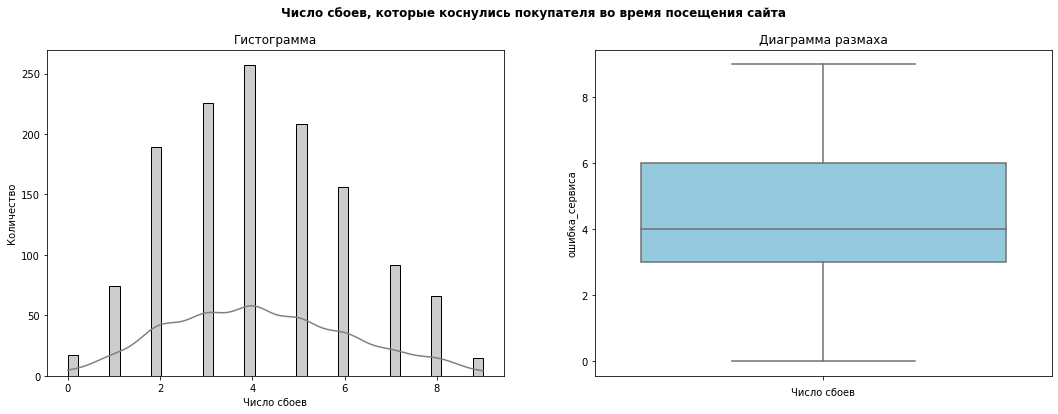

In [47]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'ошибка_сервиса'
plot_data(market_file, 'ошибка_сервиса', 'Число сбоев', 'Число сбоев, которые коснулись покупателя во время посещения сайта')

In [48]:
#Применяем функцию для проверки нормальности распределения к датасету `market_file` и столбцу 'ошибка_сервиса'
check_normality(market_file['ошибка_сервиса'])

stat=0.966, p=0.000
Распределение не является нормальным


In [49]:
#Выводим описательные статистики к датасету `market_file` и столбцу 'ошибка_сервиса'
market_file['ошибка_сервиса'].describe()

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

*В среднем при посищении сайта пользователи сталкиваются с 4мя сбоями в работе системы*

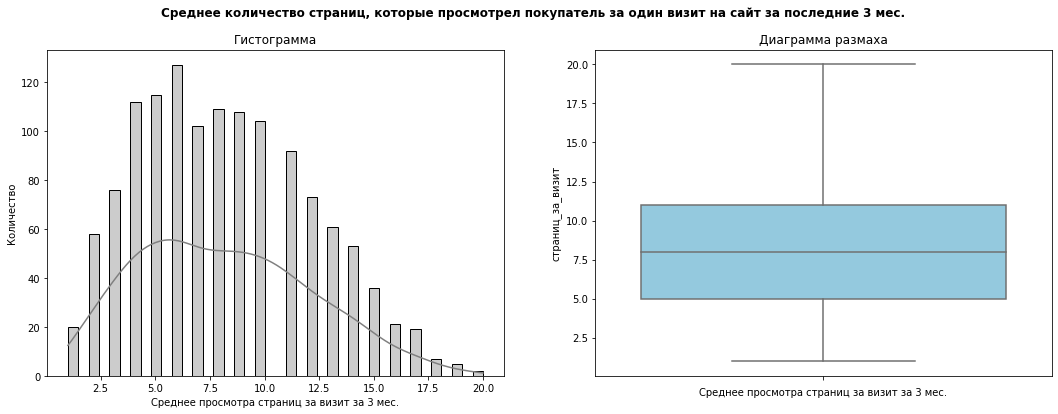

In [50]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'страниц_за_визит'
plot_data(market_file, 'страниц_за_визит', 'Среднее просмотра страниц за визит за 3 мес.', 'Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 мес.')

In [51]:
#Применяем функцию для проверки нормальности распределения к датасету `market_file` и столбцу 'страниц_за_визит'
check_normality(market_file['страниц_за_визит'])

stat=0.974, p=0.000
Распределение не является нормальным


In [52]:
#Выводим описательные статистики к датасету `market_file` и столбцу 'страниц_за_визит'
market_file['страниц_за_визит'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

*Большая часть пользователей при посещении сайт просматривают от 5 до 10 страниц.*

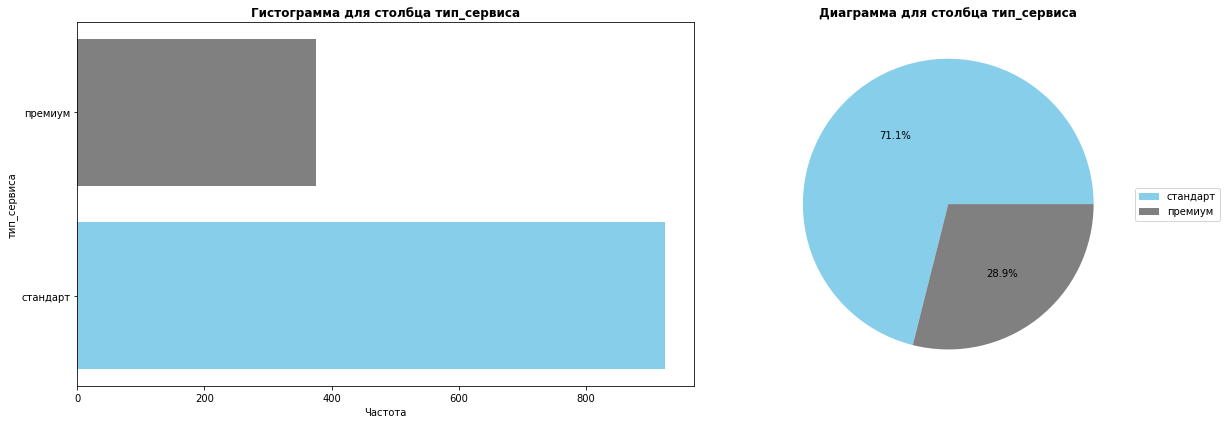

In [53]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'тип_сервиса'
plot_histogram(market_file, 'тип_сервиса')

*Для большей части пользователей характерен тип сервиса 'стандарт' в соотношение 71.1% к 28.9%.*

**Для более подробного анализа категориальных не числовых данных выделим две выборки в разрезе `тип сервиса`.**

In [54]:
standart = market_file.query('тип_сервиса == "стандарт"')
premium = market_file.query('тип_сервиса == "премиум"')

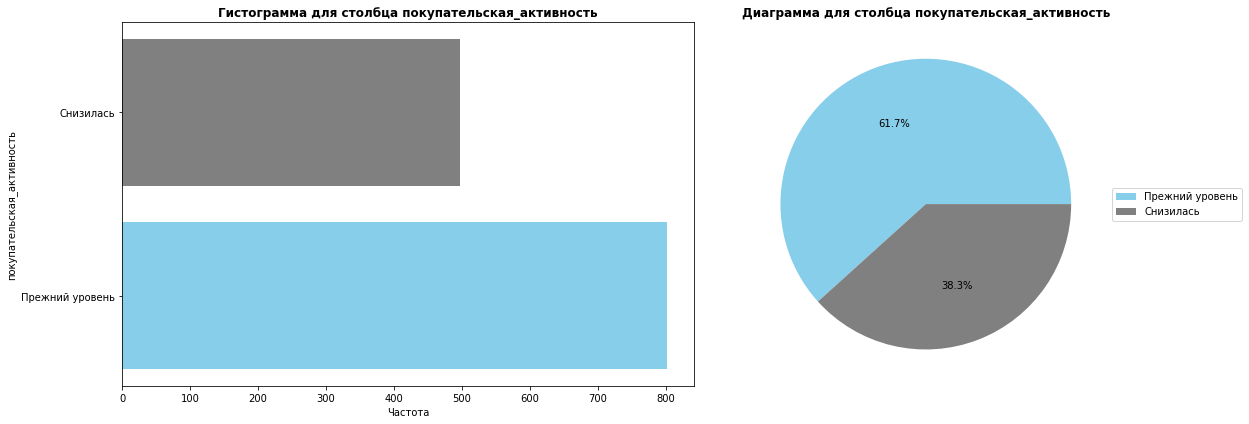

In [55]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'покупательская_активность'
plot_histogram(market_file, 'покупательская_активность')

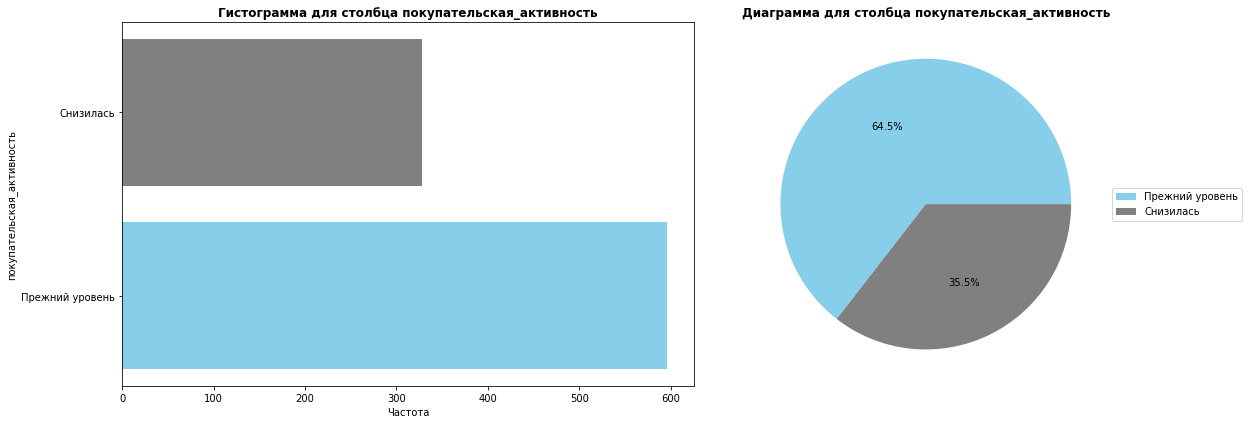

In [56]:
#Посмотрим как 'тип сервиса' - стандарт влияет на покупательскую активность.
plot_histogram(standart, 'покупательская_активность')

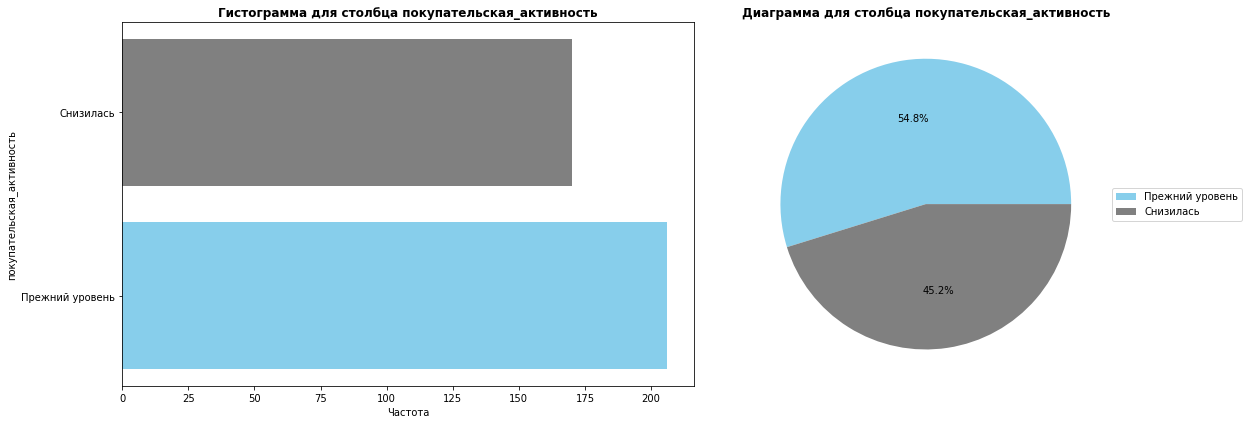

In [57]:
#Посмотрим как 'тип сервиса' - премиум влияет на покупательскую активность.
plot_histogram(premium, 'покупательская_активность')

*Соотношение покупательской активности 61.7% (прежний уровень) к 38.3% (Снизилась), так как это целевой признак следует учесть, что данные несбалансированы. Наибольшее снижение покупательской активности наблюдается среди пользователей с типом сервиса - премиум.*

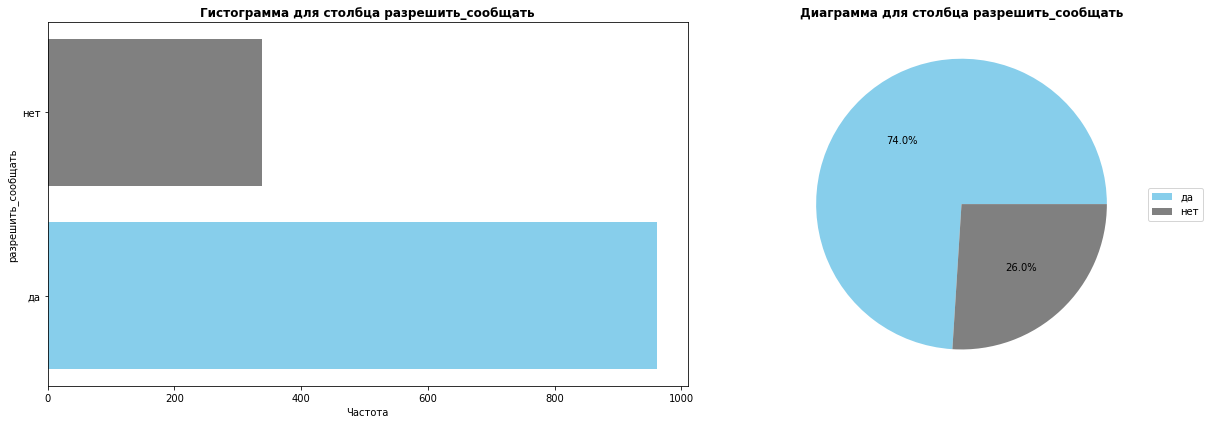

In [58]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'разрешить_сообщать'
plot_histogram(market_file, 'разрешить_сообщать')

*Большая часть пользователей дали согласие на получение дополнительных предложений о товарах.*

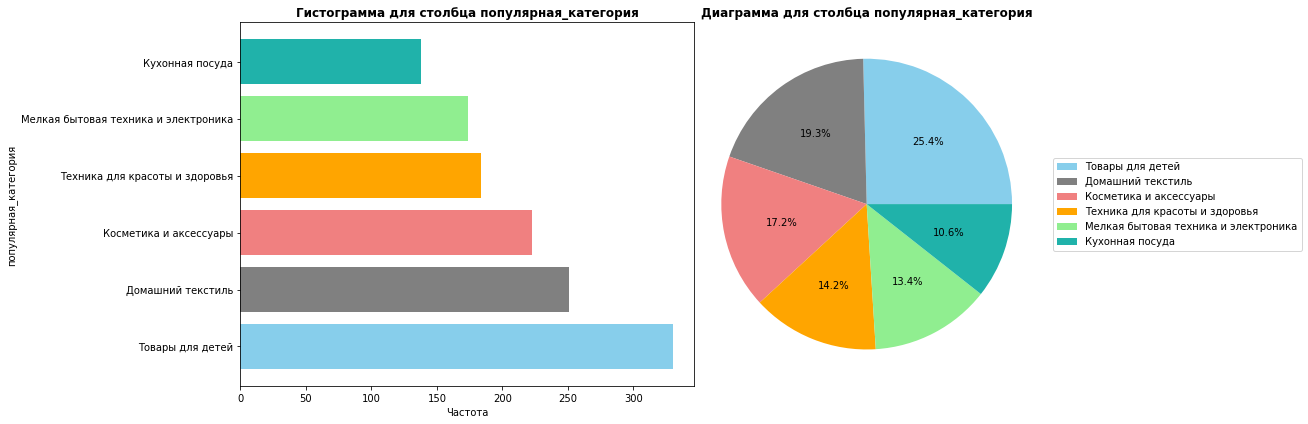

In [59]:
#Применяем функцию для построения графиков к датасету `market_file` и столбцу 'популярная_категория'
plot_histogram(market_file, 'популярная_категория')

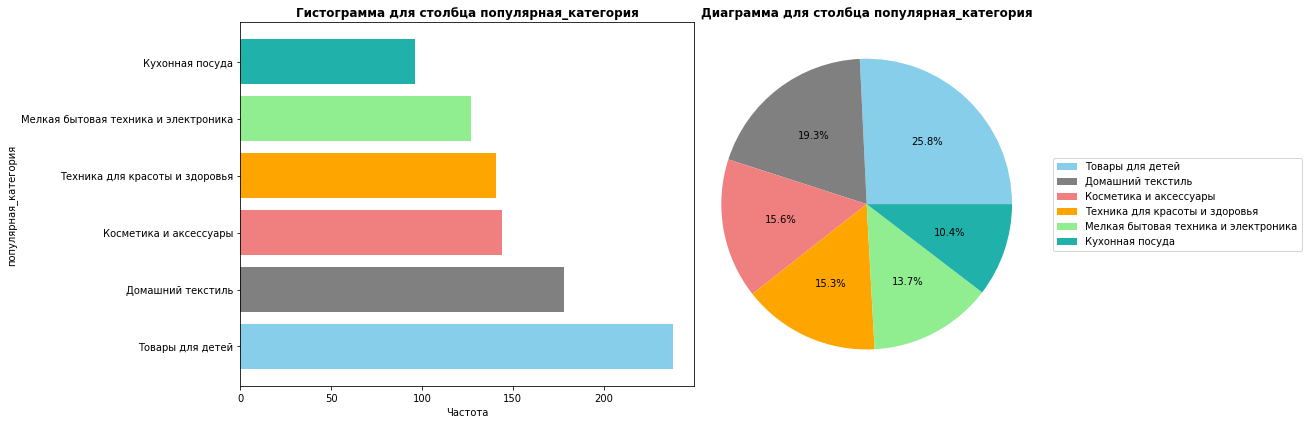

In [60]:
#Посмотрим как 'тип сервиса' - стандарт влияет на распределение категорий товаров.
plot_histogram(standart, 'популярная_категория')

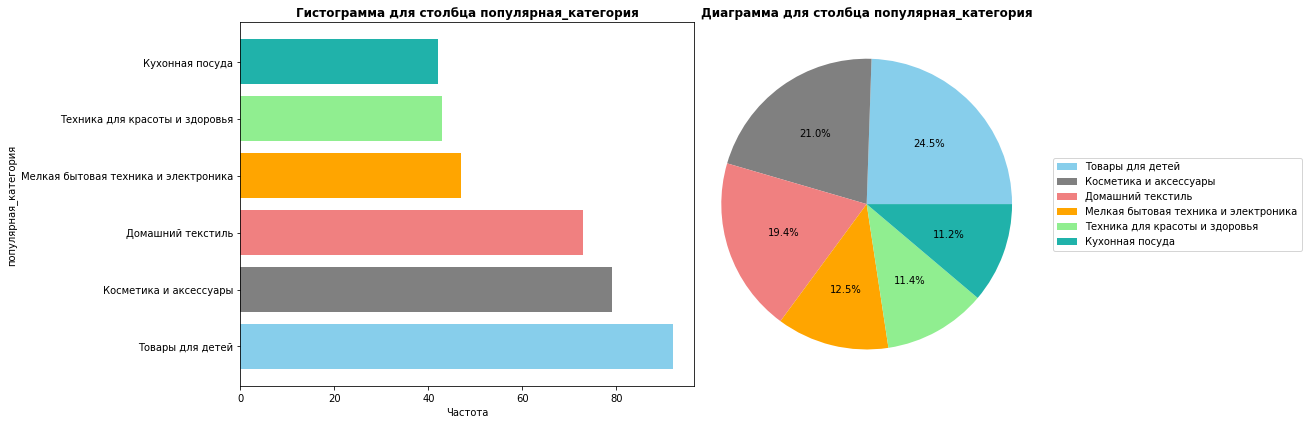

In [61]:
#Посмотрим как 'тип сервиса' - премиум влияет на распределение категорий товаров.
plot_histogram(premium, 'популярная_категория')

*Самая популярная категория - 'товары для детей', на 2ой и 3й строчке расположились 'Домашний текстиль' и 'Косметика и аксессуары'. Наименее популярными товарами является 'Кухонная посуда'. В целом покупательское поведение двух групп схоже, с небольшими различиями в процентных соотношениях распределения по категориям.*

***Исследовательский анализ датасета `market_money`***

In [62]:
#Выведем список колонок датасета `market_file`
market_money.columns

Index(['период', 'выручка'], dtype='object')

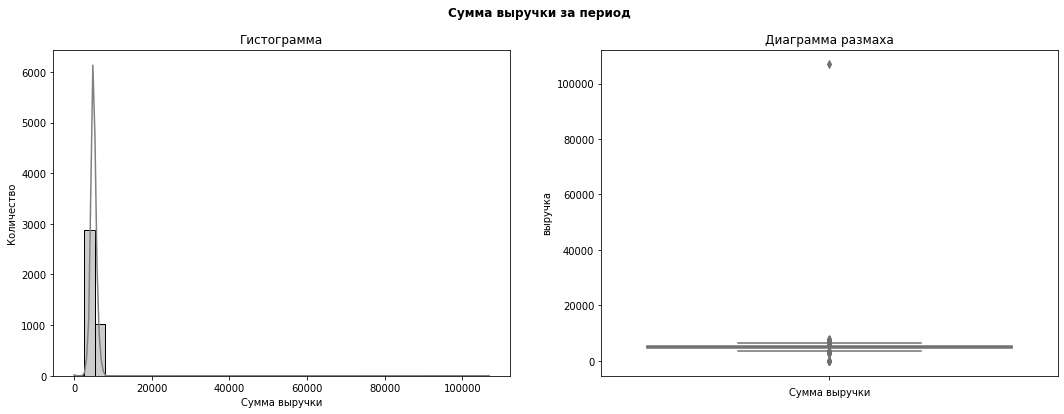

In [63]:
#Применяем функцию для построения графиков к датасету `market_money` и столбцу 'выручка'
plot_data(market_money, 'выручка', 'Сумма выручки', 'Cумма выручки за период')

In [64]:
#Применяем функцию для проверки нормальности распределения к датасету `market_money` и столбцу 'выручка'
check_normality(market_money['выручка'])

stat=0.198, p=0.000
Распределение не является нормальным


In [65]:
#Выводим описательные статистики к датасету `market_money` и столбцу 'выручка'
market_money['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

**В столбце `выручка` имеются выбросы с нулевыми значениями и очень высоким значением. Посмотрим на строки с этими значениями.**

In [66]:
market_money.loc[market_money["выручка"] > 20000]

,период,выручка
id,,
215380,текущий_месяц,106862.2


In [67]:
market_money.loc[market_money["выручка"] == 0]

,период,выручка
id,,
215348,предпредыдущий_месяц,0.0
215348,предыдущий_месяц,0.0
215357,предпредыдущий_месяц,0.0
215357,предыдущий_месяц,0.0
215359,предыдущий_месяц,0.0
215359,предпредыдущий_месяц,0.0


*По условию задачи, нужно отобрать клиентов с покупательской активностью не менее трех месяцев.*

In [68]:
#Удалим аномально высокое и нулевые значения в датасете `market_money` столбца 'выручка'
market_money = market_money.loc[(market_money["выручка"] <= 20000) & (market_money["выручка"] > 0)]

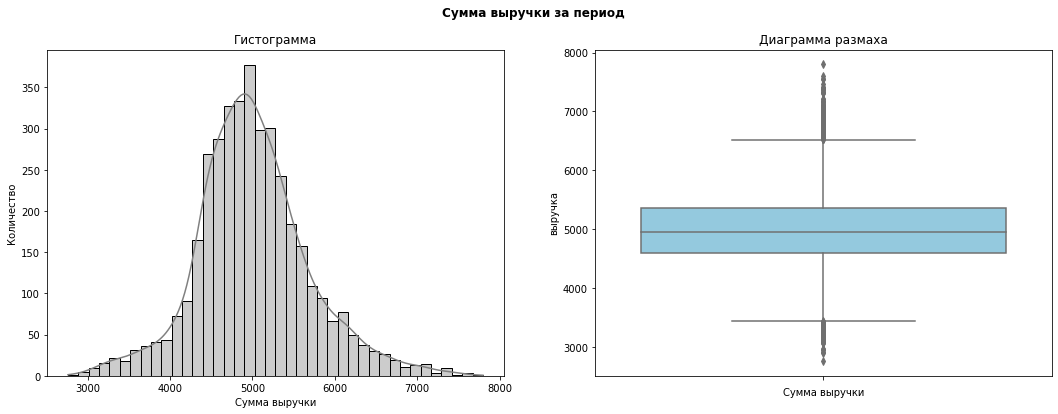

In [69]:
#Посмотрим на графики после обработки
plot_data(market_money, 'выручка', 'Сумма выручки', 'Cумма выручки за период')

In [70]:
check_normality(market_money['выручка'])

stat=0.982, p=0.000
Распределение не является нормальным


In [71]:
market_money['выручка'].describe()

count    3893.000000
mean     5007.282918
std       679.724898
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64

*Анализ столбца `'выручка'` датасета `market_money` показал наличие выбросов.*

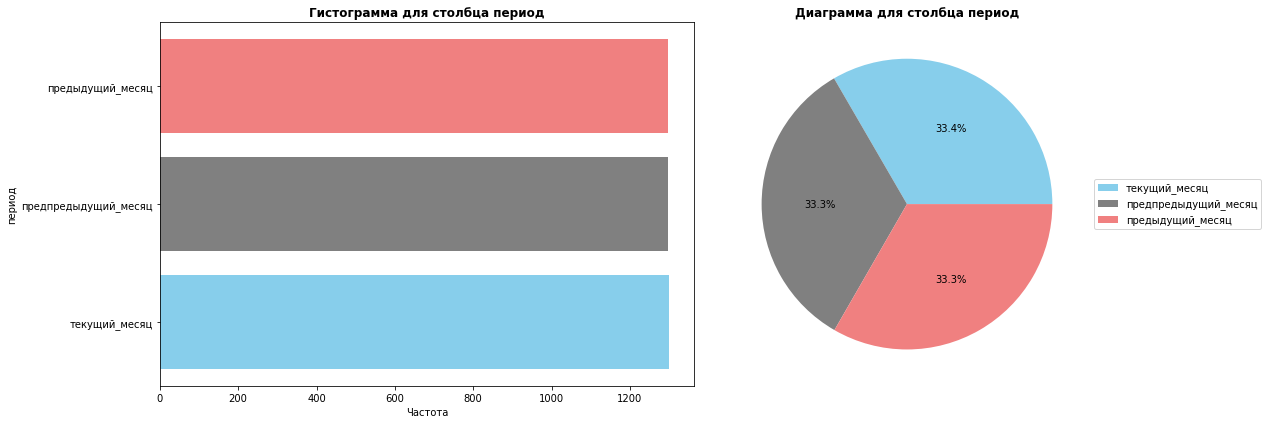

In [72]:
#Применяем функцию для построения графиков к датасету `market_money` и столбцу 'период'
plot_histogram(market_money, 'период')

*Периоды, во время которых была зафиксирована выручка распределены в равных долях.*

***Исследовательский анализ датасета `market_time`***

In [73]:
#Выведем список колонок датасета `market_time`
market_time.columns

Index(['период', 'минут'], dtype='object')

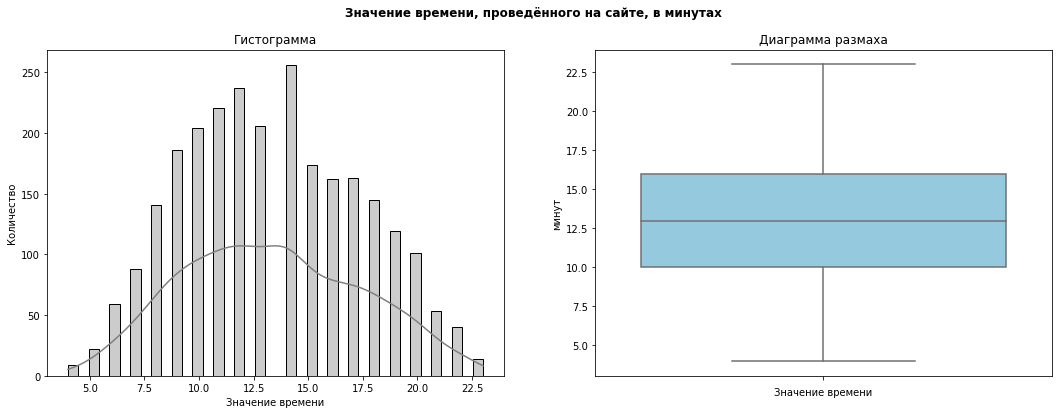

In [74]:
#Применяем функцию для построения графиков к датасету `market_time` и столбцу 'минут'
plot_data(market_time, 'минут', 'Значение времени', 'Значение времени, проведённого на сайте, в минутах')

In [75]:
#Применяем функцию для проверки нормальности распределения к датасету `market_time` и столбцу 'минут'
check_normality(market_time['минут'])

stat=0.983, p=0.000
Распределение не является нормальным


In [76]:
#Выводим описательные статистики к датасету `market_time` и столбцу 'минут'
market_time['минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

*В среднем пользователи проводят на сайте 13 минут, максимально проведенное время составляет 23 минуты.*

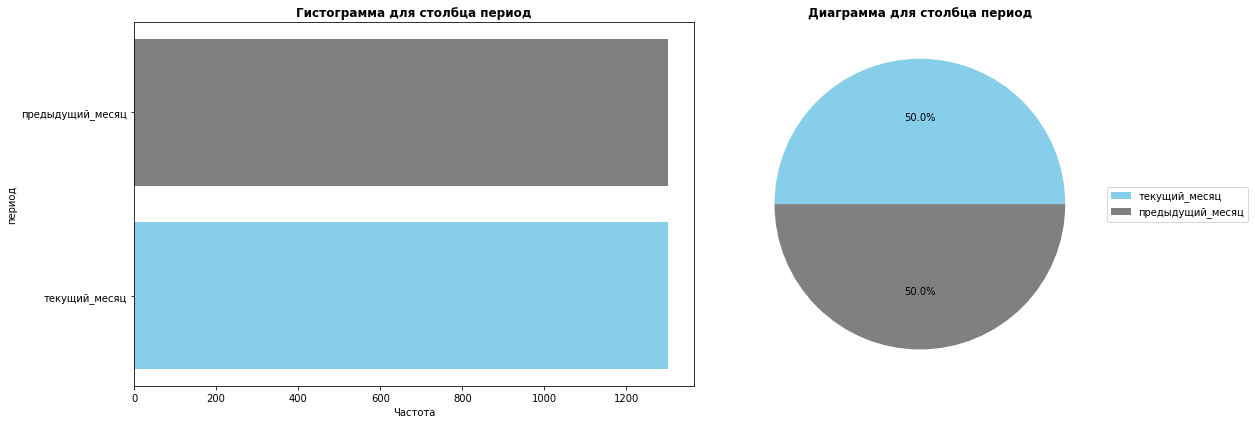

In [77]:
#Применяем функцию для построения графиков к датасету `market_time` и столбцу 'период'
plot_histogram(market_time, 'период')

*Периоды за которое было зафиксировано время проведенное на сайте имеют равное распределение.*

***Исследовательский анализ датасета `money`***

In [78]:
#Выведем список колонок датасета `money`
money.columns

Index(['прибыль'], dtype='object')

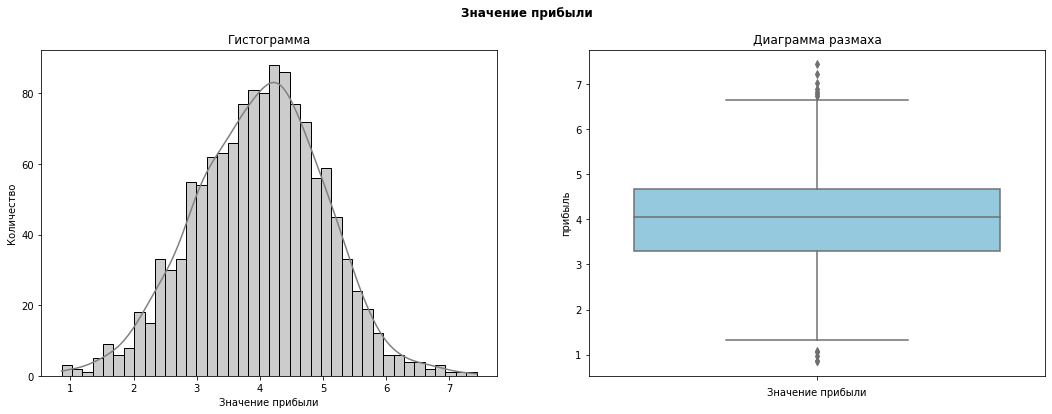

In [79]:
#Применяем функцию для построения графиков к датасету `money` и столбцу 'прибыль'
plot_data(money, 'прибыль', 'Значение прибыли', 'Значение прибыли')

In [80]:
#Применяем функцию для проверки нормальности распределения к датасету `money` и столбцу 'прибыль'
check_normality(money['прибыль'])

stat=0.998, p=0.258
Распределение является нормальным


In [81]:
#Выводим описательные статистики к датасету `money` и столбцу 'прибыль'
money['прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

*Столбец `'прибыль'` датасета `money` единственный из всего набора данных имеет нормальное распределение со средним значением 4.*

**Вывод по блоку "Исследовательский анализ данных":**

 - По результатам исследовательского анализа данных представленных датасетов можно сделать следующие заключения:
   - Все признаки имеющихся данных имеют не нормальное распределение, исключением является единственный столбец `'прибыль'` датасета `money`.
   - `'тип_сервиса'` датасета `market_file` не сильно влияет на разницу распределения покупательского поведения, однако снижение покупательской активности наиболее выражено среди пользователей с типом сервиса `премиум`.
   - Данные целевого признака `'покупательская_активность'` являются не сбалансированными, что следует учитывать в дальнейшей работе.
   - Из выявленных аномалий, можно отметить столбец `'выручка'` датасета `market_money`: были обнаружены выбросы с нулевыми значениями и одним очень высоким значением (данные значения были удалены). Нулевые значения были удалены по условию задачи. Выброс с большим значением удален по причине того, что он может оказать негативное влияние при моделировании.

## Объединение таблиц

In [82]:
#Выводим первые 5 строк на экран
market_money.head()

,период,выручка
id,,
215348,текущий_месяц,3293.1
215349,предпредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6
215349,предыдущий_месяц,5216.0
215350,предпредыдущий_месяц,4826.0


In [83]:
#Создаем сводную таблицу с отдельными столбцами о выручке за каждый период
pivot_market_money = market_money.pivot_table(index='id', columns='период', values='выручка')
pivot_market_money.columns = ['предпредыдущий_месяц_выручка', 'предыдущий_месяц_выручка', 'текущий_месяц_выручка']
pivot_market_money.head()

,предпредыдущий_месяц_выручка,предыдущий_месяц_выручка,текущий_месяц_выручка
id,,,
215348,NaN,NaN,3293.1
215349,4472.0,5216.0,4971.6
215350,4826.0,5457.5,5058.4
215351,4793.0,6158.0,6610.4
215352,4594.0,5807.5,5872.5


In [84]:
#Выводим первые 5 строк на экран
market_time.head()

,период,минут
id,,
215348,текущий_месяц,14
215348,предыдущий_месяц,13
215349,текущий_месяц,10
215349,предыдущий_месяц,12
215350,текущий_месяц,13


In [85]:
#Создаем сводную таблицу с отдельными столбцами о минутах за каждый период
pivot_market_time = market_time.pivot_table(index='id', columns='период', values='минут')
pivot_market_time.columns = ['предыдущий_месяц_минуты', 'текущий_месяц_минуты']
pivot_market_time.head()

,предыдущий_месяц_минуты,текущий_месяц_минуты
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [86]:
#Выполняем объединение методом merge() по столбцу `id` и выводим первые 5 строк получившегося датасета
general_data = (
    market_file
    .merge(pivot_market_money, on='id', how='inner')
    .merge(pivot_market_time, on='id', how='inner')
)

general_data.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предпредыдущий_месяц_выручка,предыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минуты,текущий_месяц_минуты
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11


In [87]:
#Изучаем датасет методом info()
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1300 non-null   object 
 1   тип_сервиса                          1300 non-null   object 
 2   разрешить_сообщать                   1300 non-null   object 
 3   маркет_актив_6_мес                   1300 non-null   float64
 4   маркет_актив_тек_мес                 1300 non-null   int64  
 5   длительность                         1300 non-null   int64  
 6   акционные_покупки                    1300 non-null   float64
 7   популярная_категория                 1300 non-null   object 
 8   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  ошибка_сервиса                       1300 non-null   int64  
 11  страниц_за_визит       

In [88]:
#Проверяем полученный датасет на наличие пропусков
general_data.isna().sum()

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предпредыдущий_месяц_выручка           3
предыдущий_месяц_выручка               3
текущий_месяц_выручка                  1
предыдущий_месяц_минуты                0
текущий_месяц_минуты                   0
dtype: int64

In [89]:
#Выводим строку с пропуском
general_data[general_data.isnull().any(axis=1)]

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предпредыдущий_месяц_выручка,предыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минуты,текущий_месяц_минуты
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
215357,Снизилась,стандарт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5,NaN,NaN,5986.3,12,6
215359,Снизилась,стандарт,да,4.6,5,110,0.00,Домашний текстиль,4,2,4,2,NaN,NaN,4735.0,13,11
215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7,5051.0,6077.0,NaN,12,14


In [90]:
#Заполняем пропуски в столбцах 'предпредыдущий_месяц_выручка', 'предыдущий_месяц_выручка', 'текущий_месяц_выручка' средним значением
general_data[['предпредыдущий_месяц_выручка', 'предыдущий_месяц_выручка', 'текущий_месяц_выручка']] = general_data[['предпредыдущий_месяц_выручка', 'предыдущий_месяц_выручка', 'текущий_месяц_выручка']].fillna(general_data[['предпредыдущий_месяц_выручка', 'предыдущий_месяц_выручка', 'текущий_месяц_выручка']].mean())

In [91]:
#Проверяем весь датасет на наличие пропусков после заполнения
general_data.isna().sum()

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предпредыдущий_месяц_выручка           0
предыдущий_месяц_выручка               0
текущий_месяц_выручка                  0
предыдущий_месяц_минуты                0
текущий_месяц_минуты                   0
dtype: int64

In [92]:
#Изучаем датасет методом info()
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1300 non-null   object 
 1   тип_сервиса                          1300 non-null   object 
 2   разрешить_сообщать                   1300 non-null   object 
 3   маркет_актив_6_мес                   1300 non-null   float64
 4   маркет_актив_тек_мес                 1300 non-null   int64  
 5   длительность                         1300 non-null   int64  
 6   акционные_покупки                    1300 non-null   float64
 7   популярная_категория                 1300 non-null   object 
 8   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  ошибка_сервиса                       1300 non-null   int64  
 11  страниц_за_визит       

In [93]:
general_data_copy = general_data.copy()

**Вывод по блоку "Объединение таблиц":**

 - В процессе объединения таблицы были выполнены следующие шаги и получен результат:
   - Созданы сводные таблицы с выделением периодов в отдельные колонки.
   - Объединены таблицы методом merge() по столбцу id (установленным ранее в качестве индекса).
   - Обработан и заполнен средним значением образовавшийся пропуск в колонке `'текущий_месяц_выручка'`
   - В результате объединения получили новый датасет размерностью 1300 строк и 17 колонок.

## Корреляционный анализ

**Построим матрицу корреляции для всех признаков объединенного датасета**

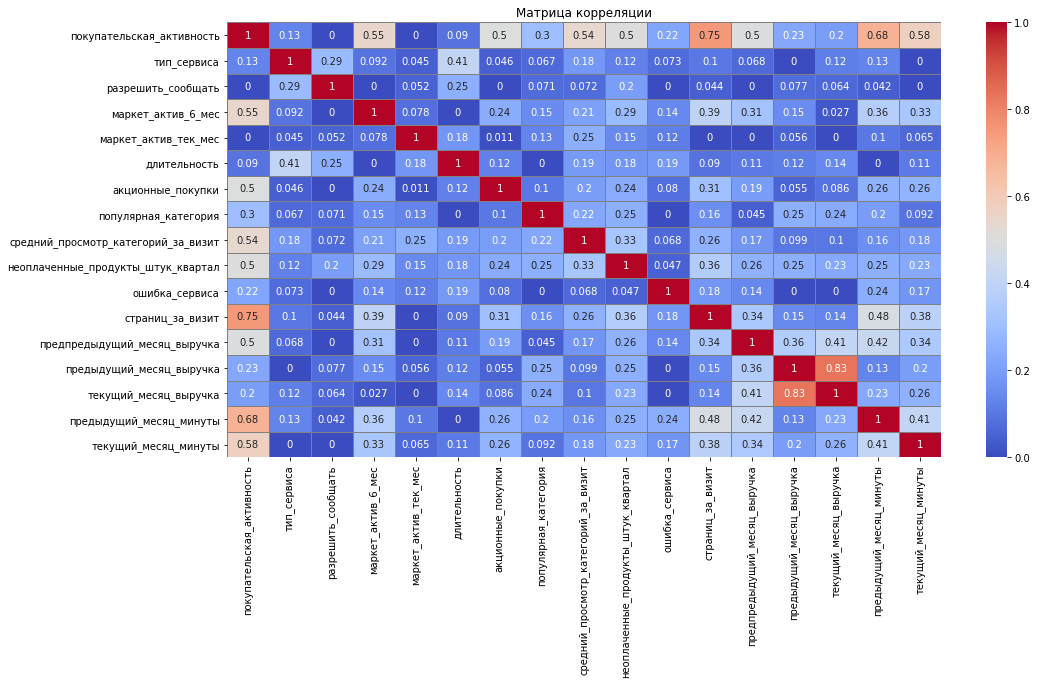

In [94]:
#Строим матрицу корреляции между признаками с помощью тепловой карты
corr_matrix = (general_data
    .phik_matrix(interval_cols=general_data
    .select_dtypes(include='number')
    .columns.tolist())
)

fig, ax = plt.subplots(figsize=(16, 8))

sn.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='grey',
    square=False,
    ax=ax
    )

ax.set_title('Матрица корреляции')
plt.show()

*Наиболее сильная корреляция наблюдается между парами признаков: `'страниц_за_визит'` и `'покупательская_активность'`; `'текущий_месяц_выручка'` и `'предпредыдущий_месяц_выручка'` со значениями 0.75 и 0.83 соответственно. Так же есть пары признаков коррелирующие немного слабее. Говорить о мультиколлинеарности не приходится, так как эти значения не привышают 0.9.*

**Построим матрицы корреляции для двух категорий целевого признака `'покупательская_активность'`**

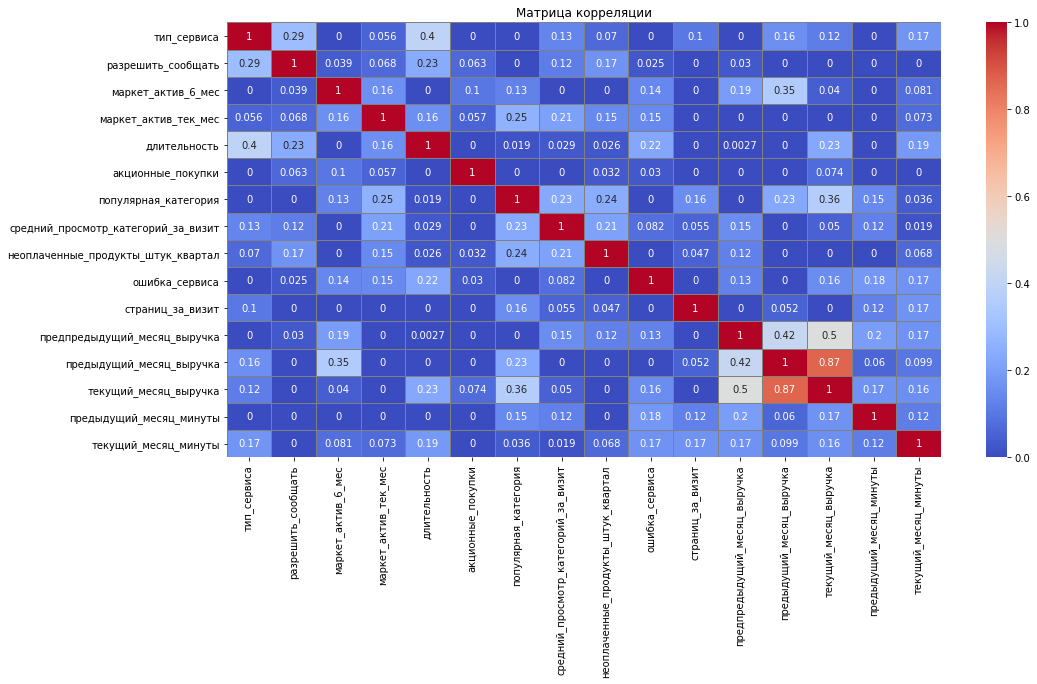

In [95]:
#Строим матрицу корреляции между признаками с помощью тепловой карты
corr_matrix = (general_data
    .query('покупательская_активность == "Прежний уровень"')
    .drop(['покупательская_активность'], axis=1)
    .phik_matrix(interval_cols=general_data
    .select_dtypes(include='number')
    .columns.tolist())
)

fig, ax = plt.subplots(figsize=(16, 8))

sn.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='grey',
    square=False,
    ax=ax
    )

ax.set_title('Матрица корреляции')
plt.show()

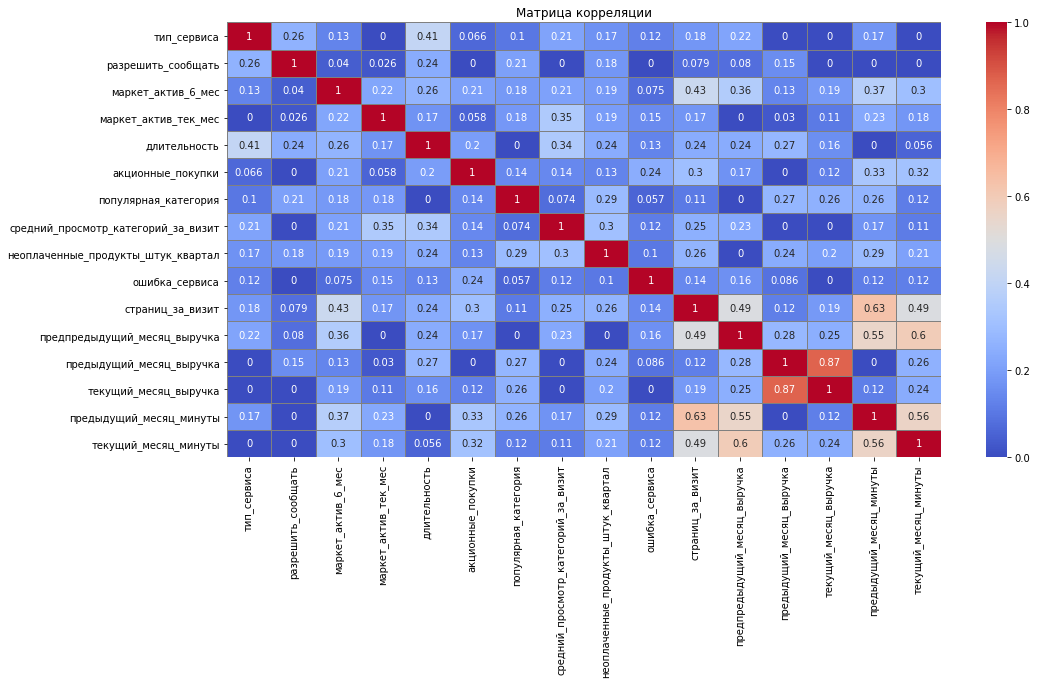

In [96]:
#Строим матрицу корреляции между признаками с помощью тепловой карты
corr_matrix = (general_data
    .query('покупательская_активность == "Снизилась"')
    .drop(['покупательская_активность'], axis=1)
    .phik_matrix(interval_cols=general_data
    .select_dtypes(include='number')
    .columns.tolist())
)

fig, ax = plt.subplots(figsize=(16, 8))

sn.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='grey',
    square=False,
    ax=ax
    )

ax.set_title('Матрица корреляции')
plt.show()

*На матрицах корреляции для двух категорий целевого признака наблюдается сильная корреляци между признаками: `'текущий_месяц_выручка'` и `'предыдущий_месяц_выручка'` со значением 0.87 в обоих случаях. Не смотря на сильную корреляцию этих признаков, о мультиколлинеарности принято говорить при значениях выше 0.9.*

**Вывод по блоку "Корреляционный анализ":**

 - В процессе корреляционного анализа были выполнены следующие шаги и сделаны выводы:
   - Построина матрица корреляции для всех признаков объединенного датасета.
   - Построины матрицы корреляции для двух категорий целевого признака `'покупательская_активность'`.
   - Наиболее сильная корреляция наблюдается между парами признаков: `'страниц_за_визит'` и `'покупательская_активность'`; `'предпредыдущий_месяц_выручка'` и `'акционные_покупки'` со значениями 0.75. Так же есть пары признаков коррелирующие немного слабее. Говорить о мультиколлинеарности не приходится, так как эти значения не привышают 0.9.
   - На матрицах корреляции для двух категорий целевого признака наблюдается сильная корреляци между признаками: `'текущий_месяц_выручка'` и `'предыдущий_месяц_выручка'`; `'предпредыдущий_месяц_выручка'` и `'акционные_покупки'`. Со значениями 0.87 и 0.9 соответственно. Не смотря на сильную корреляцию этих признаков, о мультиколлинеарности принято говорить при значениях выше 0.9.

## Использование пайплайнов

In [97]:
#Выведем список колонок объединенного датасета для удобства создания пайплайна
general_data.columns

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'предпредыдущий_месяц_выручка',
       'предыдущий_месяц_выручка', 'текущий_месяц_выручка',
       'предыдущий_месяц_минуты', 'текущий_месяц_минуты'],
      dtype='object')

In [98]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    general_data.drop(['покупательская_активность'], axis=1),
    general_data['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = general_data['покупательская_активность'])

X_train.shape, X_test.shape

((975, 16), (325, 16))

In [99]:
#Создаём списки с названиями признаков
ohe_columns = [
    'разрешить_сообщать',
    'популярная_категория'
]

ord_columns = ['тип_сервиса']

num_columns = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'предыдущий_месяц_выручка',
    'предпредыдущий_месяц_выручка', 
    'текущий_месяц_выручка',
    'предыдущий_месяц_минуты',
    'текущий_месяц_минуты'
]

In [100]:
#Кодируем целевой признак
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [101]:
#Выводим на экран результат кодирования
print(pd.DataFrame(data=label_encoder.classes_, columns=['покупательская_активность']))

  покупательская_активность
0           Прежний уровень
1                 Снизилась


In [102]:
#Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
#SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

In [103]:
#Создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
#SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [104]:
#Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [105]:
#Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [106]:
param_grid = [
#Словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
#Словарь для модели KNeighborsClassifier()    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
#Словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [107]:
#Выполняем поиск гиперпараметров
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps...
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 10),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

*Была использована метрика ROC-AUC так как она устойчива к дисбалансу классов (что было выявлено ранее), оценивает качество классификации модели вне зависимости от выбора порога вероятности для принятия решения о классификации, ее легко интерпритировать.*

In [108]:
#Выводим лучшую модель и ее параметры, и метрику лучшей модели
print('Лучшая модель и её параметры:\n', randomized_search.best_estimator_)
print ('\nМетрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                         

In [110]:
#Выводим результат метрики ROC-AUC полученный на тестовой выборке
y_test_pred = randomized_search.predict(X_test)
y_test_pred_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9002367196276682


**Вывод по блоку "Использование пайплайнов":**

 - В процессе выполнения текущего блока получили следующие результаты:
   - Была использована метрика ROC-AUC так как она устойчива к дисбалансу классов (что было выявлено ранее), оценивает качество классификации модели вне зависимости от выбора порога вероятности для принятия решения о классификации, ее легко интерпритировать.
   - Лучшей моделью оказалась KNeighborsClassifier с гиперпараметром n_neighbors=6. Метрика на тренировочной выборке составила 0.89, а на тестовой 0.9.

## Анализ важности признаков

In [111]:
shap.initjs()
best_model = randomized_search.best_estimator_
X_train_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].fit_transform(X_train), 
    columns= pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
X_test_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].fit_transform(X_test), 
    columns= pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
model = KNeighborsClassifier(n_neighbors=8)
model.fit(X_train_shap, y_train)
explainer = shap.Explainer(model.predict_proba, X_train_shap)
shap_values = explainer(X_test_shap)

PermutationExplainer explainer: 326it [01:11,  4.11it/s]                         


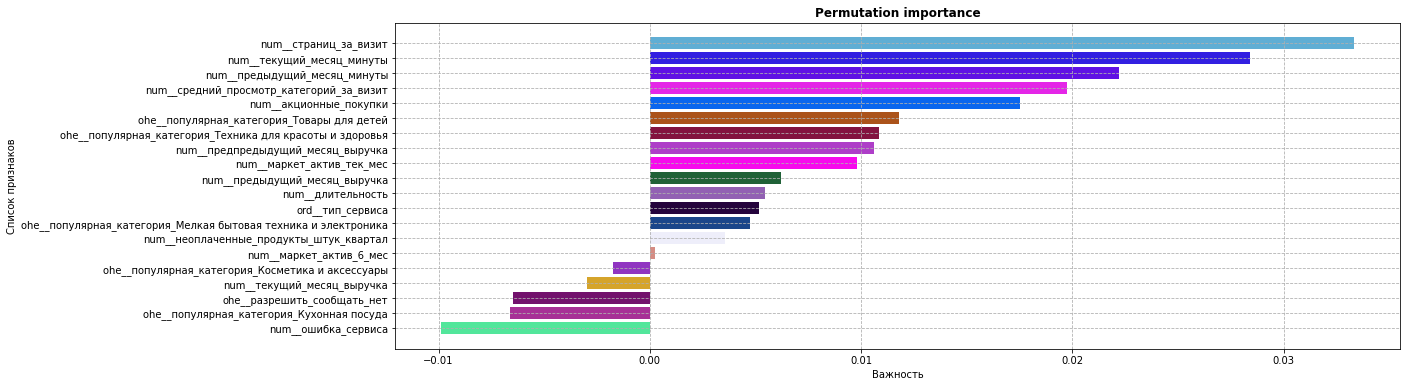

In [112]:
result = permutation_importance(model, X_test_shap, y_test, scoring='roc_auc')

permutation_score = pd.DataFrame(data={
    'column': X_test_shap.columns,
    'importances_mean': result.importances_mean,
    'importances_std': result.importances_std
})

permutation_score = permutation_score.sort_values(by='importances_mean', ascending=True)


colors = np.random.rand(len(permutation_score), 3)

plt.figure(figsize=(18, 6))
plt.barh(permutation_score['column'], permutation_score['importances_mean'], color=colors)
plt.title('Permutation importance', fontweight='bold')
plt.xlabel('Важность')
plt.ylabel('Список признаков')
plt.grid(linestyle='--')
plt.show()

*Среди наиболее важных признаков выявленных с помощью Permutation importance оказались: `'страниц_за_визит'`, `'предыдущий_месяц_минуты'`, `'текущий_месяц_минуты'` c примерно равным значением. Чуть ниже идет `'средний_просмотр_категорий_за_визит'`*

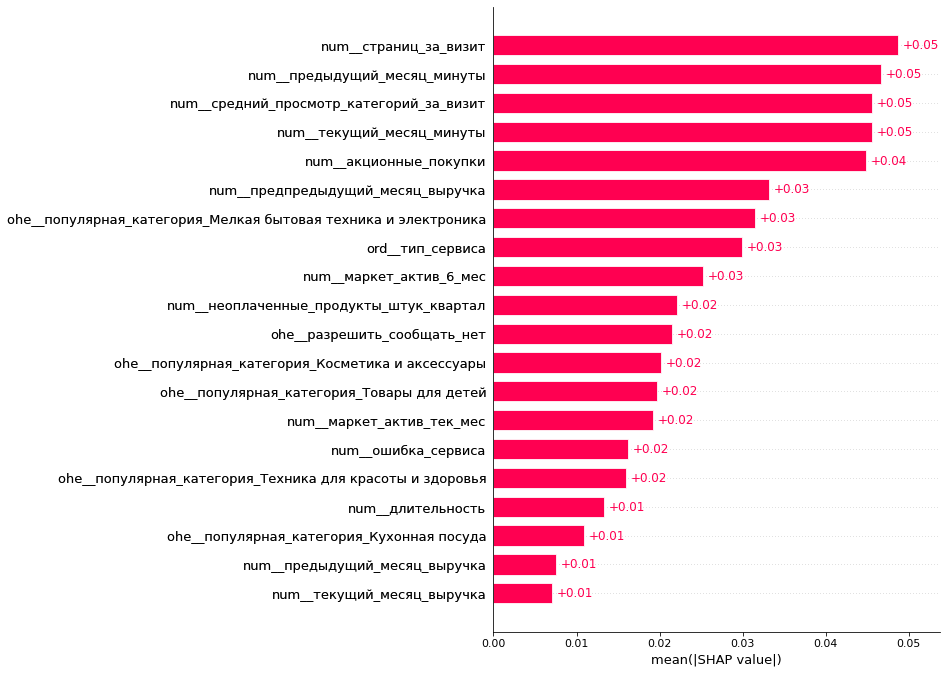

In [113]:
shap.plots.bar(shap_values[:,:,1], max_display = 20)

*SHAP показал среди наиболее важных признаков `'страниц_за_визит'`, `'средний_просмотр_категорий_за_визит'`, `'текущий_месяц_минуты'`. Среди наименее важных можно отметить: `'популярная_категория_Кухонная_посуда'`, `'предпредыдущий_месяц_выручка'`, `'текущий_месяц_выручка'`*

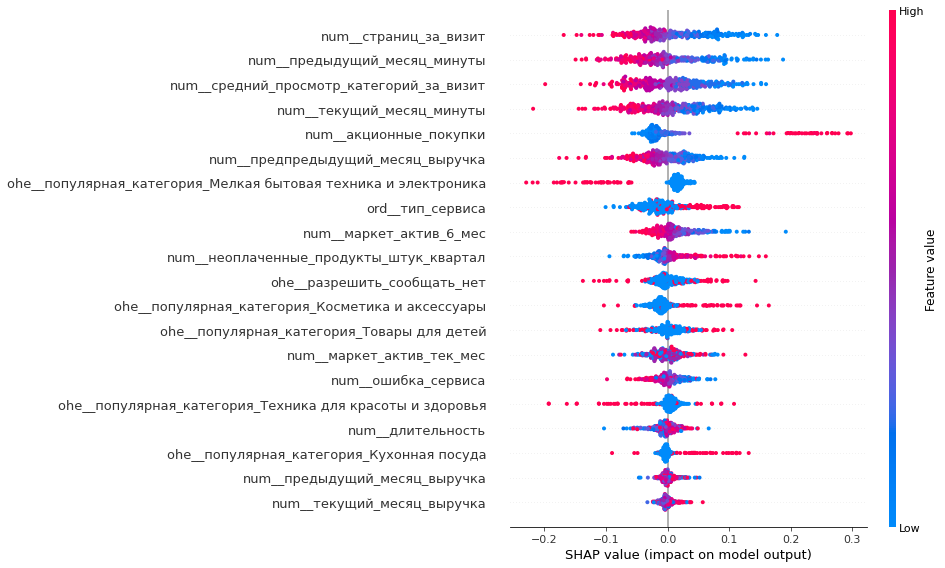

In [114]:
shap.plots.beeswarm(shap_values[:,:,1], max_display = 20) 

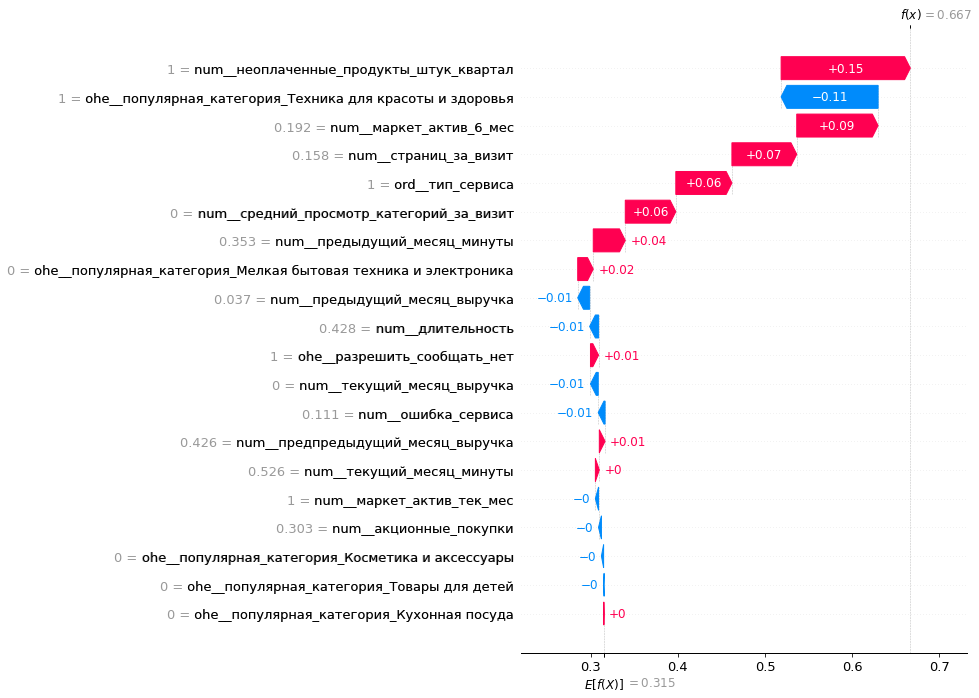

In [115]:
shap.plots.waterfall(shap_values[1,:,1], max_display = 20)

**Вывод по блоку "Анализ важности признаков":**

 - В процессе анализа важности признаков были получены следующие результаты:
   - Наиболее важным признаком является признак `'страниц_за_визит'`, так же в тройке лидеров: `'текущий_месяц_минуты'`, `'предыдущий_месяц_минуты'`. Чем ниже их значения, тем больше вероятность того, что модель спрогнозирует снижение покупательской активности.
   - Среди наименее важных можно отметить: `'предыдущий_месяц_выручка'`, `'предпредыдущий_месяц_выручка'`, `'текущий_месяц_выручка'`.

## Сегментация покупателей

In [116]:
#Создаем функцию для построения графиков (гистограмма для двух датасетов) для числовых значений
def plot_dual_histogram(x, y):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    sn.histplot(data=segmentation, x=x, ax=axs[0], bins=40, kde=True, alpha=0.4, color='grey')
    axs[0].set_xlabel(x)
    axs[0].set_ylabel('Количество')
    axs[0].set_title('Гистограмма - Сегментация')

    sn.histplot(data=general_data_copy, x=x, ax=axs[1], bins=40, kde=True, alpha=0.4, color='grey')
    axs[1].set_xlabel(x)
    axs[1].set_ylabel('Количество')
    axs[1].set_title('Гистограмма - Общая')

    fig.suptitle(y, fontweight='bold')
    plt.show()

In [117]:
segmentation_data = general_data_copy.merge(money, on = 'id')

In [118]:
segmentation_data.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предпредыдущий_месяц_выручка,предыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минуты,текущий_месяц_минуты,прибыль
id,,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,4836.367772,4948.33963,3293.1,13,14,0.98
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.000000,5216.00000,4971.6,12,10,4.16
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.000000,5457.50000,5058.4,8,13,3.13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.000000,6158.00000,6610.4,11,13,4.87
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.000000,5807.50000,5872.5,8,11,4.21


In [119]:
segmentation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1300 non-null   object 
 1   тип_сервиса                          1300 non-null   object 
 2   разрешить_сообщать                   1300 non-null   object 
 3   маркет_актив_6_мес                   1300 non-null   float64
 4   маркет_актив_тек_мес                 1300 non-null   int64  
 5   длительность                         1300 non-null   int64  
 6   акционные_покупки                    1300 non-null   float64
 7   популярная_категория                 1300 non-null   object 
 8   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  ошибка_сервиса                       1300 non-null   int64  
 11  страниц_за_визит       

In [120]:
segmentation_data['прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

*Выделим сегмент пользователей у которых покупательская активность снизилась, а прибыль выше третего квартиля, так как их уход будет означать большую потерю выручки для бизнеса.*

In [121]:
segmentation = segmentation_data[(segmentation_data['покупательская_активность'] == 'Снизилась') & (segmentation_data['прибыль'] > 4.7)]

In [122]:
segmentation.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предпредыдущий_месяц_выручка,предыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минуты,текущий_месяц_минуты,прибыль
id,,,,,,,,,,,,,,,,,,
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.000000,6158.00000,6610.4,11,13,4.87
215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,4749.000000,3263.00000,3772.6,12,10,5.26
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксессуары,2,2,1,3,4433.000000,4146.50000,4566.4,6,7,4.93
215359,Снизилась,стандарт,да,4.6,5,110,0.00,Домашний текстиль,4,2,4,2,4836.367772,4948.33963,4735.0,13,11,5.08
215368,Снизилась,премиум,да,3.8,5,829,0.24,Техника для красоты и здоровья,2,2,6,1,4536.000000,5823.00000,5591.6,11,9,6.27


In [123]:
segmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 215351 to 215931
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            109 non-null    object 
 1   тип_сервиса                          109 non-null    object 
 2   разрешить_сообщать                   109 non-null    object 
 3   маркет_актив_6_мес                   109 non-null    float64
 4   маркет_актив_тек_мес                 109 non-null    int64  
 5   длительность                         109 non-null    int64  
 6   акционные_покупки                    109 non-null    float64
 7   популярная_категория                 109 non-null    object 
 8   средний_просмотр_категорий_за_визит  109 non-null    int64  
 9   неоплаченные_продукты_штук_квартал   109 non-null    int64  
 10  ошибка_сервиса                       109 non-null    int64  
 11  страниц_за_визит        

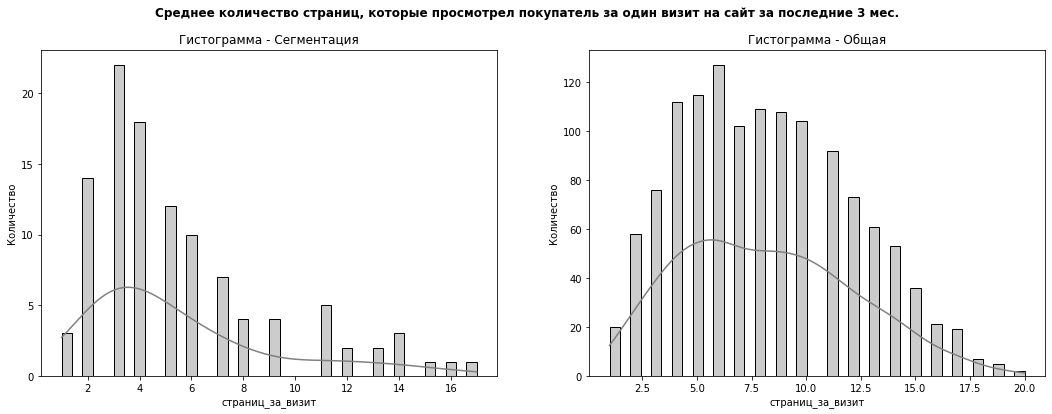

In [124]:
plot_dual_histogram('страниц_за_визит', 'Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 мес.')

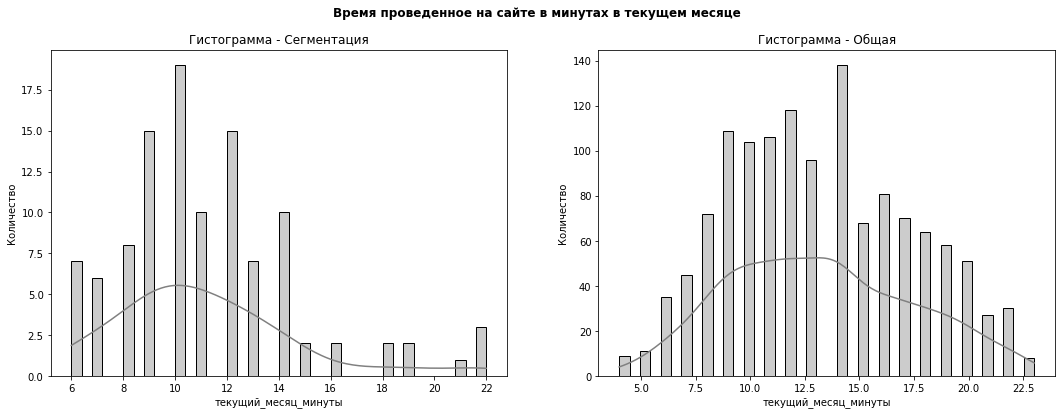

In [125]:
plot_dual_histogram('текущий_месяц_минуты', 'Время проведенное на сайте в минутах в текущем месяце')

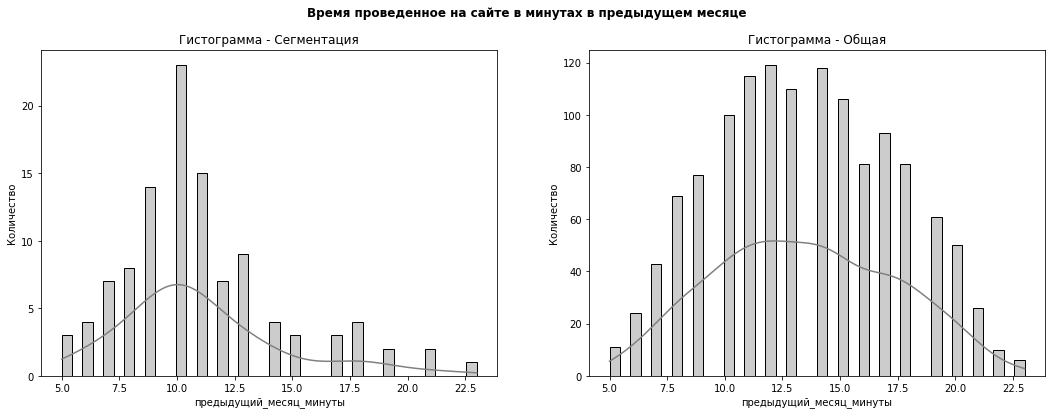

In [126]:
plot_dual_histogram('предыдущий_месяц_минуты', 'Время проведенное на сайте в минутах в предыдущем месяце')

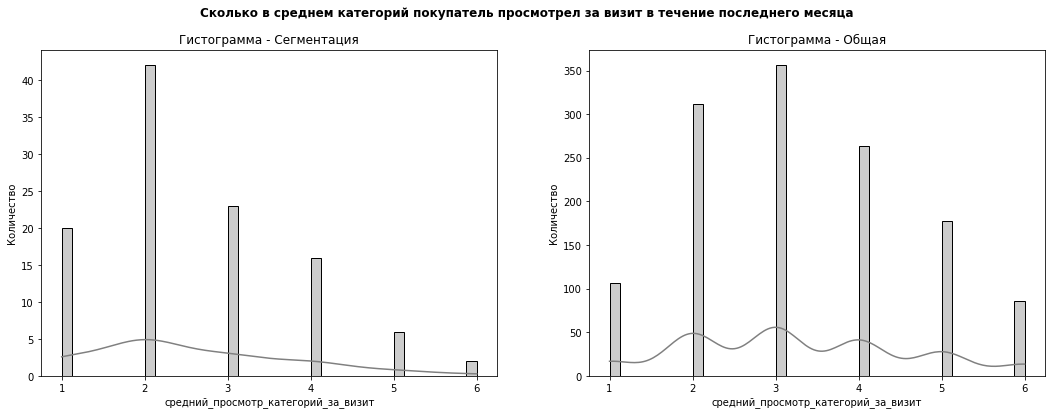

In [127]:
plot_dual_histogram('средний_просмотр_категорий_за_визит', 'Сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца')

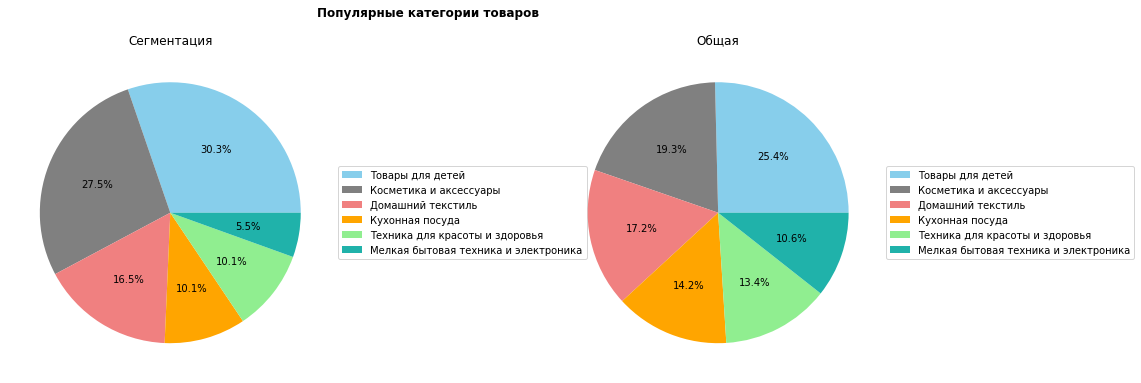

In [128]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
colors = ['skyblue', 'grey', 'lightcoral', 'orange', 'lightgreen', 'lightseagreen']

counts = segmentation['популярная_категория'].value_counts()
counts_1 = general_data['популярная_категория'].value_counts()
legend_labels = counts.index
legend_labels_1 = counts_1.index

axs[0].pie(counts, colors=colors[:len(counts)], autopct='%1.1f%%')
axs[0].set_title('Сегментация')
axs[0].legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

axs[1].pie(counts_1, colors=colors[:len(counts_1)], autopct='%1.1f%%')
axs[1].set_title('Общая')
axs[1].legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle('Популярные категории товаров', fontweight='bold')
plt.show()

**Вывод по блоку "Сегментация покупателей":**

 - В процессе сегментации был выделен следующий сегмент и выполнен сравнительный анализ:
   - Выделен сегмент пользователей у которых покупательская активность снизилась, а прибыль выше третего квартиля, так как их уход будет означать большую потерю выручки для бизнеса.
   - Среди выделенного сегмента пользователей наблюдаются следующие тенденции: 
   1. Снижение количества просмотренных страниц за визит, за последние 3 месяца.
   2. Снижение общего времени проведенного на сайте за все периоды.
   3. Меньшее количество просмотренных категорий за визит.
   4. Снижение интереса к некоторым категориям товаров.

## Общий вывод

**Задача:**
   - Промаркировать уровень финансовой активности постоянных покупателей. 
   - Собрать данные по клиентам.
   - Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента.
   - Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

***В процессе работы были выполнены следующие шаги и получены результаты:***

*Загрузка данных:*
 - Данные всех датасетов загружены верно, типы данных не требуют преобразования, все данные соответствуют описанию.
   - Датасет `market_file` содержит 1300 строк и 13 колонок с числовыми и строковыми данными.
   - Датасет `market_money` содержит 3900 строк и 3 колонки с числовыми и строковыми данными.
   - Датасет `market_time` содержит 2600 строк и 3 колонки с числовыми и строковыми данными.
   - Датасет `money` содержит 1300 строк и 2 колонки с числовыми данными.
   
*Предобработка данных:*
 - В представленных датасетах пропуски и явные дубликаты отсутствуют. Но были выявлены и исправлены следующие аномалии:
   - Датасет `market_file` столбец `['Тип сервиса']` - выявлен и исправлен неявный дубликат.
   - Датасет `market_file` столбец `['Популярная_категория']` - выявлено и исправлено некорректное название категории.
   - Датасет `market_money` столбец `['Период']` - выявлено и исправлено некорректное название категории.
   - Датасет `market_time` столбец `['Период']` - выявлено и исправлено некорректное название категории.
   
   - Название колонок во всех датасетах приведено в нормельный вид в соответствии с общепринятой стилистикой.
   - Для всех датасетов в качестве индекса установлен столбец id.
   
*Поиск лучшей модели:*
 - Для поиска лучшей модели был построен пайплайн, в котором использовались масштабирования данных, осуществлялся подбор модели и гиперпараметров.
 - В результате работы пайплана была выбрана лучшая модель со следующими параметрами: KNeighborsClassifier(n_neighbors=6).
 
*Работа по сегментации:*
 - В процессе сегментации был выделен следующий сегмент пользователей: сегмент пользователей у которых покупательская активность снизилась, а прибыль выше третего квартиля, так как их уход будет означать большую потерю выручки для бизнеса.
   - Рекомендации:
   1. Проработать визуал сайта, добавить рекомендации по товарам для данной категории пользователей. Предложить скидки или акции на приобретение дополнительных товаров к текущему заказу. Данные действия так же поспособствуют увеличению среднего времени проведенного на сайте и повысит общий интерес пользователей.
   2. Провести анализ товарного ассортимента: качество товаров, качество используемых материалов, упаковка и т.д.
   3. Расширение ассортимента магазина, провести аналитику среди пользователей выбранного сегмента, выяснить какие категории товаров были бы им интересны.